# 1. Data Loading

### 1.1 Create PyTorch Datasets and DataLoaders

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
import datetime
from pathlib import Path
from tqdm.notebook import tqdm

# PyTorch libraries
import torch
from torch.utils.data import DataLoader
import wandb

from utils.data_persistence import load_scalers
from utils.training_utils import plot_training_history, plot_predictions
from utils.wandb_utils import setup_wandb
from utils.training_utils import train_model, evaluate_model
from utils.wandb_utils import setup_wandb

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


# List of features to use
AVAILABLE_FEATURES = [
    'ghi',                     # Target variable
    'air_temperature',         # Weather features
    'wind_speed',
    'relative_humidity',
    'dew_point',
    'surface_pressure',
    'total_precipitable_water',
    'cloud_type',              # Cloud features
    'cloud_fill_flag',
    'cld_opd_dcomp',
    'cld_press_acha',
    'cld_reff_dcomp',
    'clearsky_ghi',            # Clear sky estimates
    'clearsky_dni',
    'clearsky_dhi',
    'solar_zenith_angle',      # Solar geometry
    'surface_albedo',          # Surface properties
    'ozone',                   # Atmospheric properties
    'aod',
    'ssa',
    'asymmetry',
    'alpha'
]

# Choose features to use in modeling
SELECTED_FEATURES = [
    'air_temperature',
    'wind_speed',
    'relative_humidity',
    'cloud_type',
    'solar_zenith_angle',
    'clearsky_ghi',
    'total_precipitable_water',
    'surface_albedo'
]

# Target variable
TARGET_VARIABLE = 'ghi'


Using cpu device


In [2]:
from utils.data_persistence import load_normalized_data

train_preprocessed_data_path = "data/processed/train_normalized.h5"
val_preprocessed_data_path = "data/processed/val_normalized.h5"
test_preprocessed_data_path = "data/processed/test_normalized.h5"

# Load sequences
train_data, metadata = load_normalized_data(train_preprocessed_data_path)

scaler_path = "data/processed/model_scalers.pkl"
scalers = load_scalers(scaler_path)

# Print metadata
print(f"Train set | Metadata: {metadata}")
# Print created time
print(f"Train set | Created time: {metadata['created_time'] if 'created_time' in metadata else 'No created time'}")
# Print raw files
print(f"Train set | Raw files: {metadata['raw_files'] if 'raw_files' in metadata else 'No raw files'}")

# Print data structure and shape
print(f"Train set | Data structure:")
for key, value in train_data.items():
    print(f"  {key} shape: {value.shape}")


Loaded normalized data from data/processed/train_normalized.h5
Loaded 12 scalers from data/processed/model_scalers.pkl
Train set | Metadata: {'created_time': '2025-04-25 05:36:18'}
Train set | Created time: 2025-04-25 05:36:18
Train set | Raw files: No raw files
Train set | Data structure:
  air_temperature shape: (8760, 105)
  clearsky_ghi shape: (8760, 105)
  cloud_type shape: (8760, 105)
  coordinates shape: (105, 2)
  elevation shape: (105,)
  ghi shape: (8760, 105)
  nighttime_mask shape: (8760, 105)
  relative_humidity shape: (8760, 105)
  solar_zenith_angle shape: (8760, 105)
  surface_albedo shape: (8760, 105)
  time_features shape: (8760, 8)
  total_precipitable_water shape: (8760, 105)
  wind_speed shape: (8760, 105)


In [3]:
from utils.timeseriesdataset import TimeSeriesDataset

LOOKBACK = 24

# Create datasets
train_dataset = TimeSeriesDataset(train_preprocessed_data_path, lookback=LOOKBACK)
val_dataset = TimeSeriesDataset(val_preprocessed_data_path, lookback=LOOKBACK)
test_dataset = TimeSeriesDataset(test_preprocessed_data_path, lookback=LOOKBACK)

# Create data loaders
batch_size = 64
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Check sample batch
sample_batch = next(iter(train_loader))
for key, value in sample_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")


Loaded normalized data from data/processed/train_normalized.h5
Loaded normalized data file (1/1): data/processed/train_normalized.h5
Loaded data with 13 features
Temporal features: ['time_features']
Static features: ['coordinates', 'elevation']
Time series features: ['air_temperature', 'clearsky_ghi', 'cloud_type', 'ghi', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Dataset dimensions: 8760 timesteps, 105 locations
Dataset contains 917280 possible samples
Loaded normalized data from data/processed/val_normalized.h5
Loaded normalized data file (1/1): data/processed/val_normalized.h5
Loaded data with 13 features
Temporal features: ['time_features']
Static features: ['coordinates', 'elevation']
Time series features: ['air_temperature', 'clearsky_ghi', 'cloud_type', 'ghi', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Dataset dimensions: 876

In [4]:
# Get a batch to determine input dimensions
batch = next(iter(train_loader))

# Method 1: Extract dimensions from a batch (more reliable)
temporal_features = batch['temporal_features']
static_features = batch['static_features']

# Check if we have 3D temporal features (batch, seq_len, features)
if len(temporal_features.shape) == 3:
    temporal_dim = temporal_features.shape[2]
else:
    # Handle 2D temporal features (batch, features)
    temporal_dim = temporal_features.shape[1]

static_dim = static_features.shape[1]

print(f"  Input dimensions determined from batch:")
print(f"  - Temporal dimension: {temporal_dim}")
print(f"  - Static dimension: {static_dim}")


  Input dimensions determined from batch:
  - Temporal dimension: 8
  - Static dimension: 2


## 2. Model Training Setup

## 2.1 Setting parameters

In [5]:
from torchinfo import summary

from utils.training_utils import train_model, evaluate_model
from utils.wandb_utils import is_wandb_enabled, set_wandb_flag, set_keep_run_open
from utils.model_utils import print_model_info

# Default settings
USE_WANDB = True
WANDB_USERNAME = "tin-hoang"
WANDB_PROJECT = "EEEM073-Solar-Radiation"

# Enable wandb tracking
set_wandb_flag(USE_WANDB)
# Keep the wandb run open after training to continue logging evaluation plots
set_keep_run_open(True)

N_EPOCHS = 10
PATIENCE = 10
LR = 0.001
DEBUG_MODE = True


## 2.2 Setup Experiment Pipeline

In [6]:
def run_experiment_pipeline(model, train_loader, val_loader, test_loader, model_name, epochs=30, patience=5, lr=0.001):
    """
    Run the experiment pipeline for a given model.

    Args:
        model: The model to train.
        train_loader: The training data loader.
        val_loader: The validation data loader.
        test_loader: The test data loader.
        model_name: The name of the model.
        epochs: The number of epochs to train the model.
        patience: The number of epochs to wait before early stopping.
        lr: The learning rate for the model.
    """
    print(f"Training {model_name} model...")
    history = train_model(
        model,
        train_loader,
        val_loader,
        model_name=model_name,
        epochs=epochs,
        patience=patience,
        lr=lr,
        debug_mode=DEBUG_MODE
    )
    training_plot = plot_training_history(history, model_name=model_name)

    print(f"Evaluating {model_name} model on validation set...")
    val_metrics = evaluate_model(
        model,
        val_loader,
        scalers[f'{TARGET_VARIABLE}_scaler'],
        model_name=f"{model_name} - Validation"
    )
    val_plot = plot_predictions(val_metrics, model_name=f"{model_name} - Validation")

    print(f"\nEvaluating {model_name} model on test set...")
    test_metrics = evaluate_model(
        model,
        test_loader,
        scalers[f'{TARGET_VARIABLE}_scaler'],
        model_name=f"{model_name} - Test"
    )
    test_plot = plot_predictions(test_metrics, model_name=f"{model_name} - Test")

    # Log the test plot to wandb
    if is_wandb_enabled():
        wandb.log({"plots/history_plot": wandb.Image(training_plot)})
        wandb.log({"plots/predictions_plot": wandb.Image(val_plot)})
        wandb.log({"plots/predictions_plot": wandb.Image(test_plot)})

    # Save the model
    torch.save(model.state_dict(), f'{model_name}_best.pt')

    # Finish wandb run if it's still open
    if is_wandb_enabled():
        wandb.finish()

    return history, val_metrics, test_metrics


# 3. Model Experiments

### 3.1 LSTM Model

In [7]:
from models.lstm import LSTMModel

# Create LSTM model
lstm_model = LSTMModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    hidden_dim=128,
    num_layers=2,
    dropout=0.3
).to(device)

# Print the model
print_model_info(lstm_model)


Model: LSTMModel
Total parameters: 215,777
Trainable parameters: 215,777
Non-trainable parameters: 0

Model structure:
LSTMModel(
  (lstm): LSTM(8, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bn_lstm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (static_proj): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=160, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_feature

Training LSTM model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Creating new wandb run for LSTM


wandb: Currently logged in as: tin-hoang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10


Epoch 1/10 | Train Loss: 0.0003, Train MAE: 0.0004 | Val Loss: 0.0002, Val MAE: 0.0003 | LR: 0.001000
Epoch 2/10


Epoch 2/10 | Train Loss: 0.0002, Train MAE: 0.0003 | Val Loss: 0.0002, Val MAE: 0.0003 | LR: 0.001000
Epoch 3/10


Epoch 3/10 | Train Loss: 0.0001, Train MAE: 0.0003 | Val Loss: 0.0002, Val MAE: 0.0003 | LR: 0.001000
Epoch 4/10


Epoch 4/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0001, Val MAE: 0.0003 | LR: 0.001000
Epoch 5/10


Epoch 5/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0001, Val MAE: 0.0002 | LR: 0.001000
Epoch 6/10


Epoch 6/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0001, Val MAE: 0.0002 | LR: 0.001000
Epoch 7/10


Epoch 7/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 8/10


Epoch 8/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 9/10


Epoch 9/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 10/10


Epoch 10/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
LOADING BEST MODEL FROM TRAINING SESSION
Keeping wandb run open as requested (keep_run_open=True)


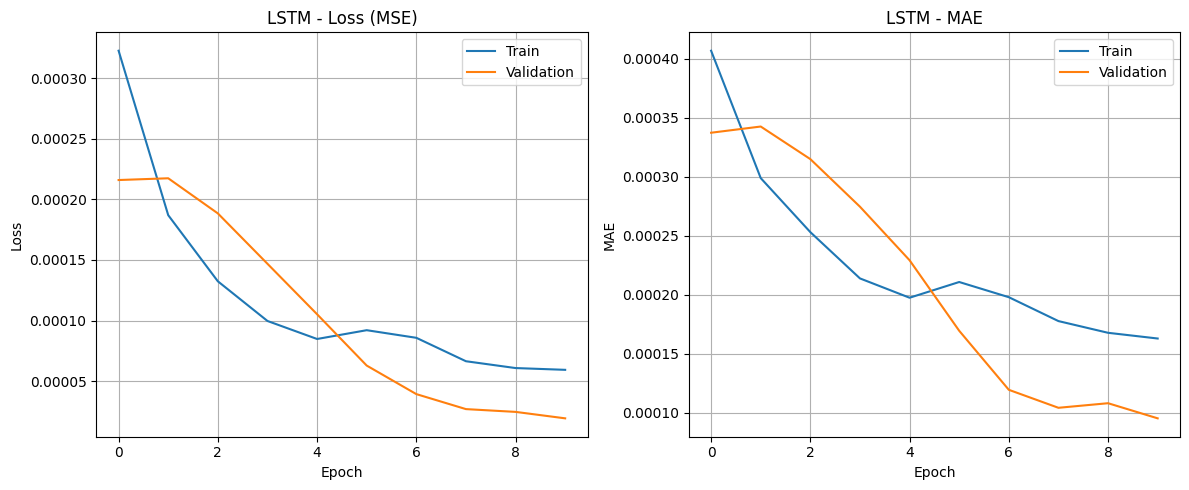

Evaluating LSTM model on validation set...

LSTM - Validation Evaluation Metrics:
  Overall:  MSE: 26254.04, RMSE: 162.03, MAE: 127.00, R²: 0.7232
  Daytime:  MSE: 26254.04, RMSE: 162.03, MAE: 127.00, R²: 0.7232
  Nighttime metrics: Not available (no nighttime data)


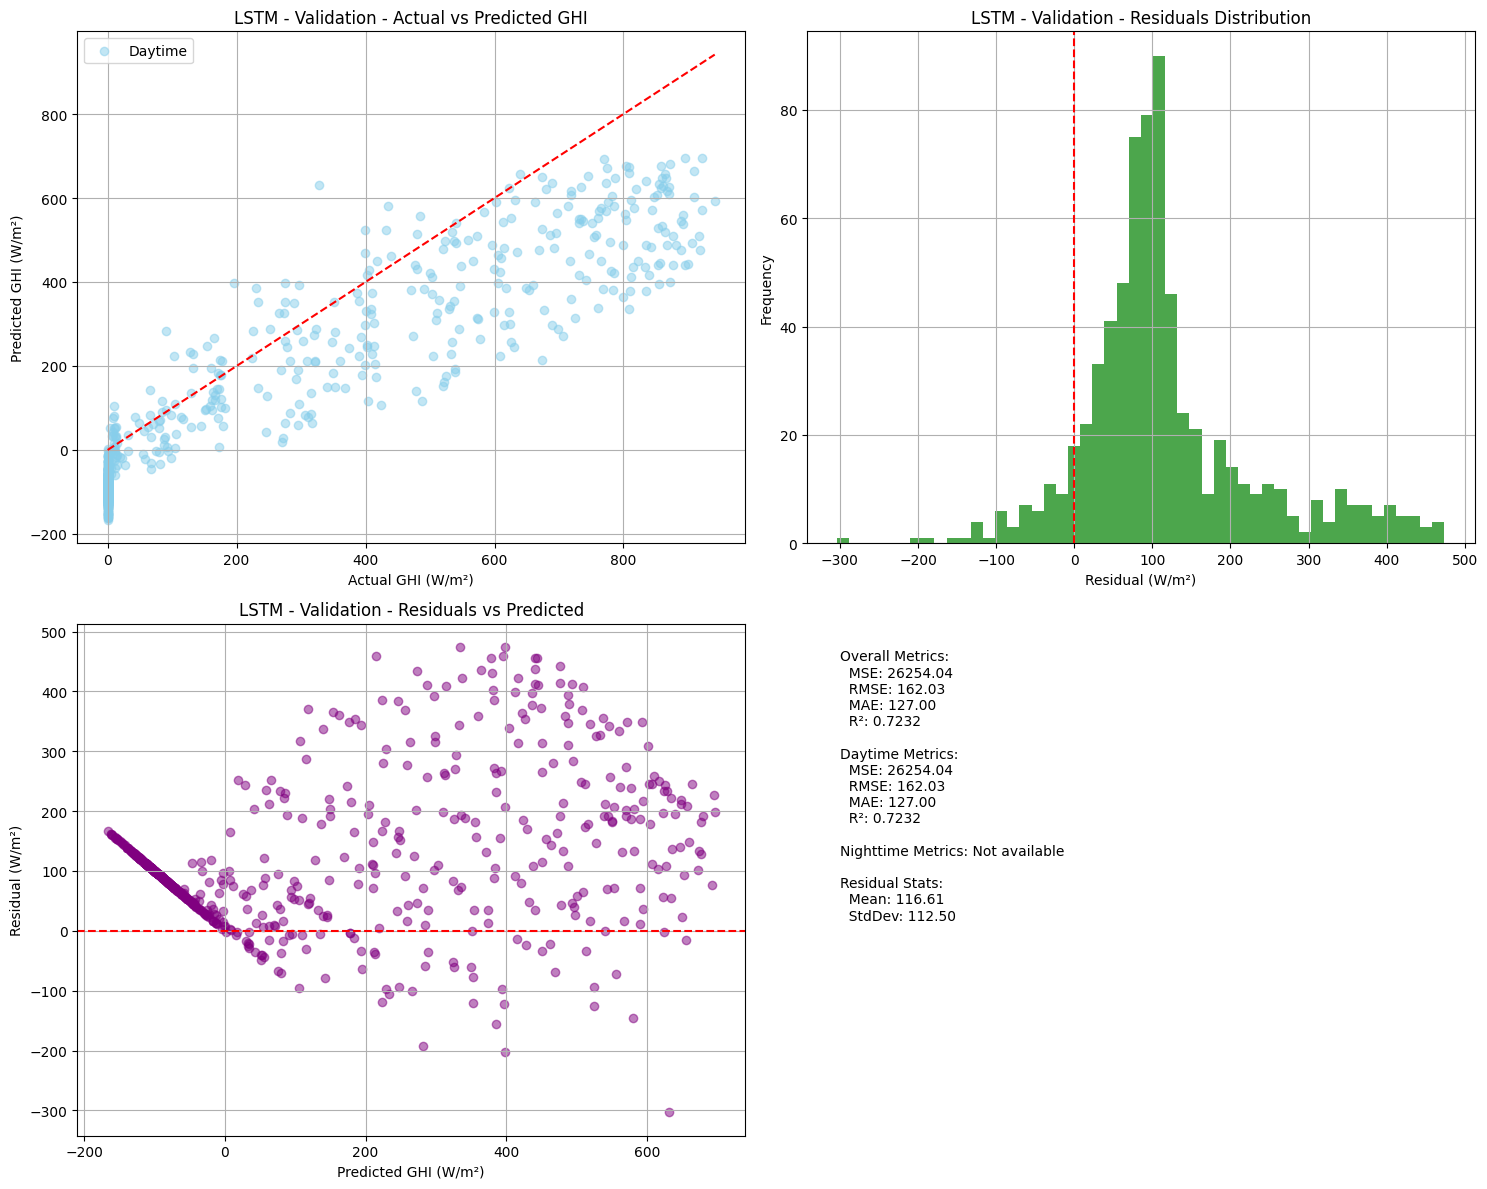


Evaluating LSTM model on test set...

LSTM - Test Evaluation Metrics:
  Overall:  MSE: 29914.67, RMSE: 172.96, MAE: 134.68, R²: 0.7039
  Daytime:  MSE: 29914.67, RMSE: 172.96, MAE: 134.68, R²: 0.7039
  Nighttime metrics: Not available (no nighttime data)


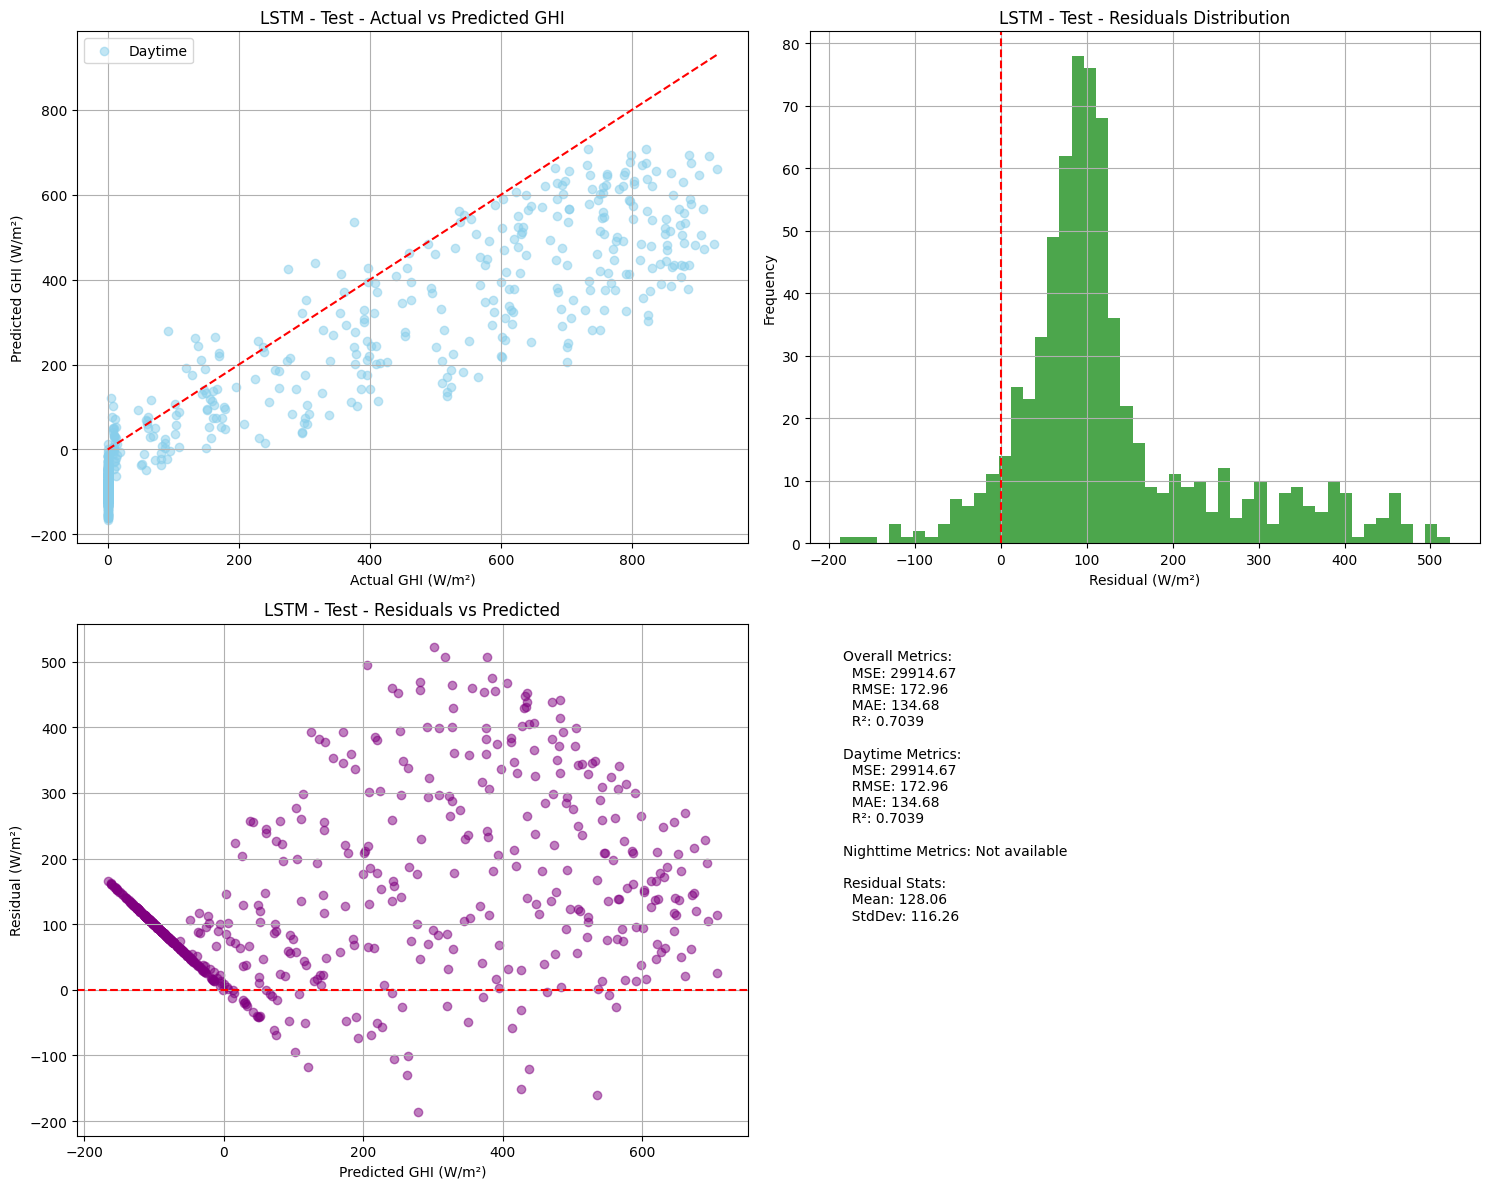

test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▂▃▃▄▅▆▆▇█
train/learning_rate,▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▃▂▂▂▂▁▁▁
train/mae,█▅▄▂▂▂▂▁▁▁
val/epoch,▁▂▃▃▄▅▆▆▇█
val/loss,██▇▆▄▃▂▁▁▁
val/mae,▁▁▁▁▁▁▁▁▁▁█


In [8]:
model_name = "LSTM"

# Train the LSTM model
lstm_history, lstm_val_metrics, lstm_test_metrics = run_experiment_pipeline(
    lstm_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)


### 3.2 CNN-LSTM Model

In [9]:
from models.cnn_lstm import CNNLSTMModel

# Create CNN-LSTM model
cnn_lstm_model = CNNLSTMModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    hidden_dim=128,
    num_filters=64,
    kernel_size=3,
    num_layers=2,
    dropout=0.3
).to(device)

# Print the model
print_model_info(cnn_lstm_model)


Model: CNNLSTMModel
Total parameters: 303,905
Trainable parameters: 303,905
Non-trainable parameters: 0

Model structure:
CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bn_lstm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (static_proj): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_r

Training CNN-LSTM model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Creating new wandb run for CNN-LSTM


Epoch 1/10


Epoch 1/10 | Train Loss: 0.0002, Train MAE: 0.0003 | Val Loss: 0.0001, Val MAE: 0.0002 | LR: 0.001000
Epoch 2/10


Epoch 2/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0001, Val MAE: 0.0002 | LR: 0.001000
Epoch 3/10


Epoch 3/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0001, Val MAE: 0.0002 | LR: 0.001000
Epoch 4/10


Epoch 4/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0001, Val MAE: 0.0001 | LR: 0.001000
Epoch 5/10


Epoch 5/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 6/10


Epoch 6/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 7/10


Epoch 7/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 8/10


Epoch 8/10 | Train Loss: 0.0000, Train MAE: 0.0001 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 9/10


Epoch 9/10 | Train Loss: 0.0000, Train MAE: 0.0001 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 10/10


Epoch 10/10 | Train Loss: 0.0000, Train MAE: 0.0001 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
LOADING BEST MODEL FROM TRAINING SESSION
Keeping wandb run open as requested (keep_run_open=True)


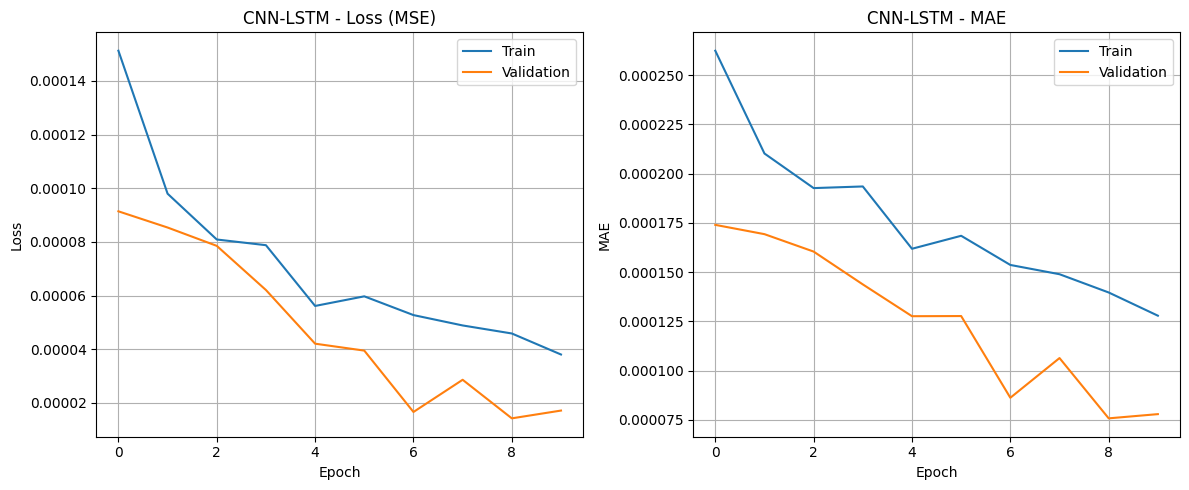

Evaluating CNN-LSTM model on validation set...

CNN-LSTM - Validation Evaluation Metrics:
  Overall:  MSE: 23313.41, RMSE: 152.69, MAE: 103.63, R²: 0.7542
  Daytime:  MSE: 23313.41, RMSE: 152.69, MAE: 103.63, R²: 0.7542
  Nighttime metrics: Not available (no nighttime data)


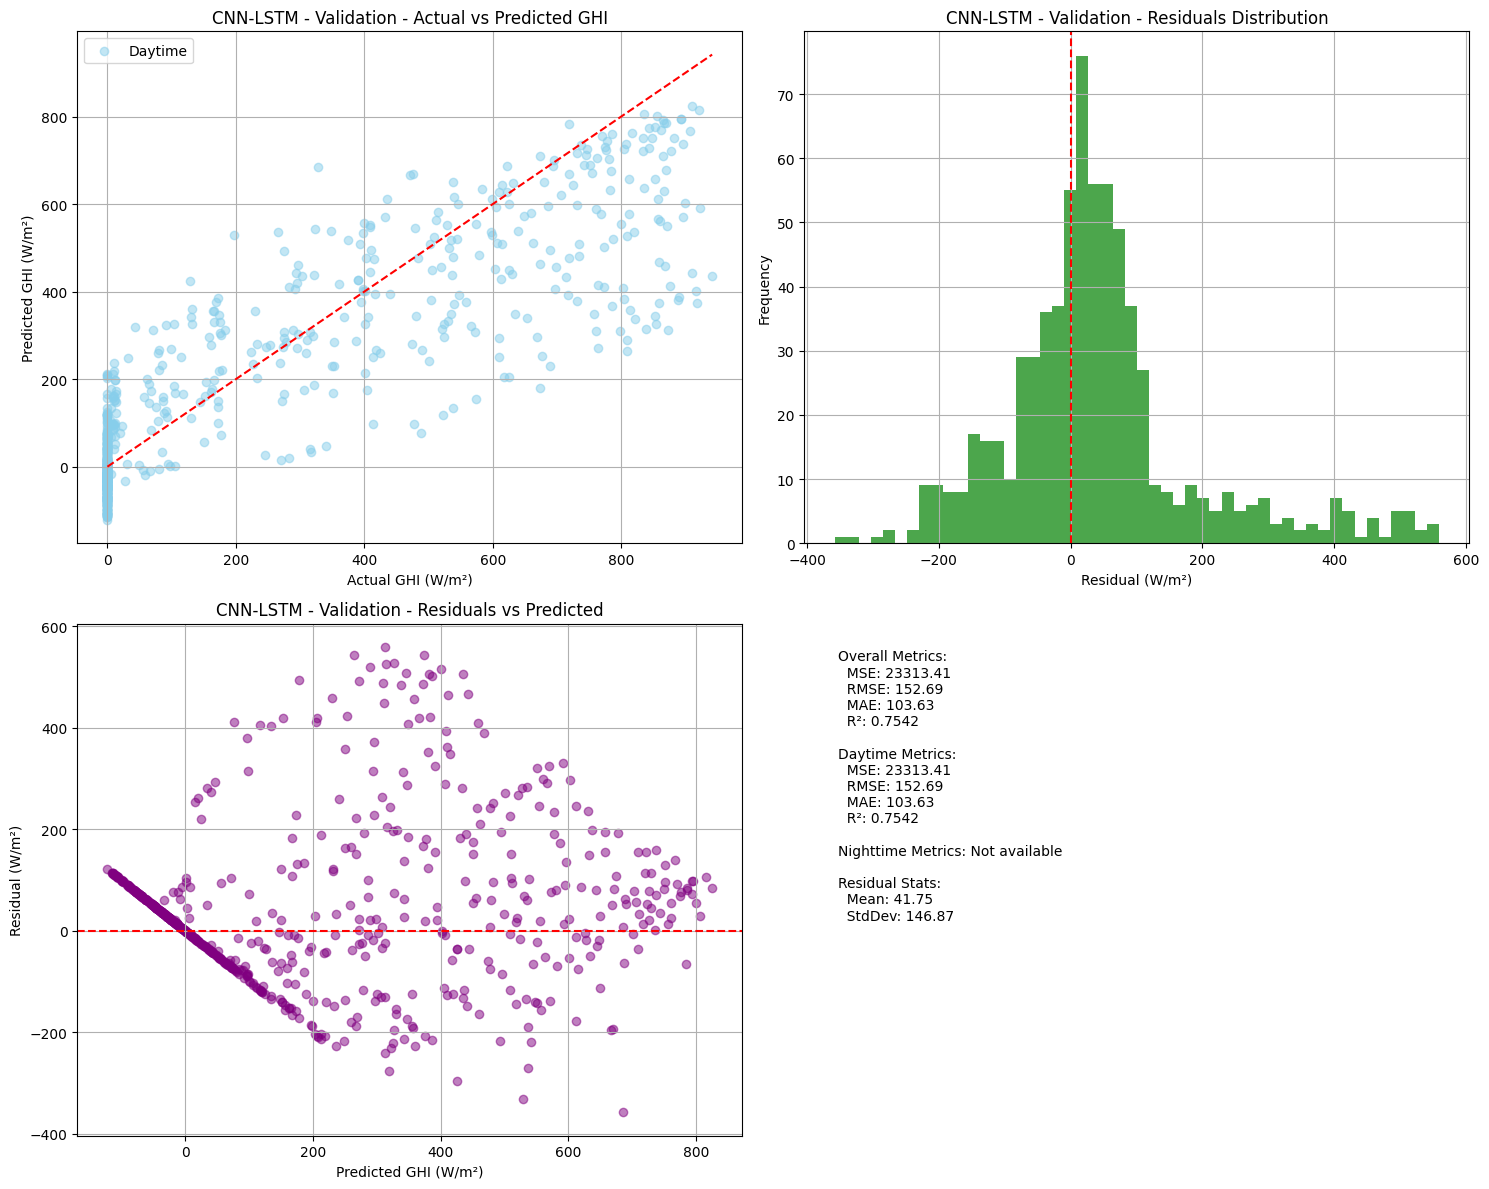


Evaluating CNN-LSTM model on test set...

CNN-LSTM - Test Evaluation Metrics:
  Overall:  MSE: 27384.88, RMSE: 165.48, MAE: 114.14, R²: 0.7290
  Daytime:  MSE: 27384.88, RMSE: 165.48, MAE: 114.14, R²: 0.7290
  Nighttime metrics: Not available (no nighttime data)


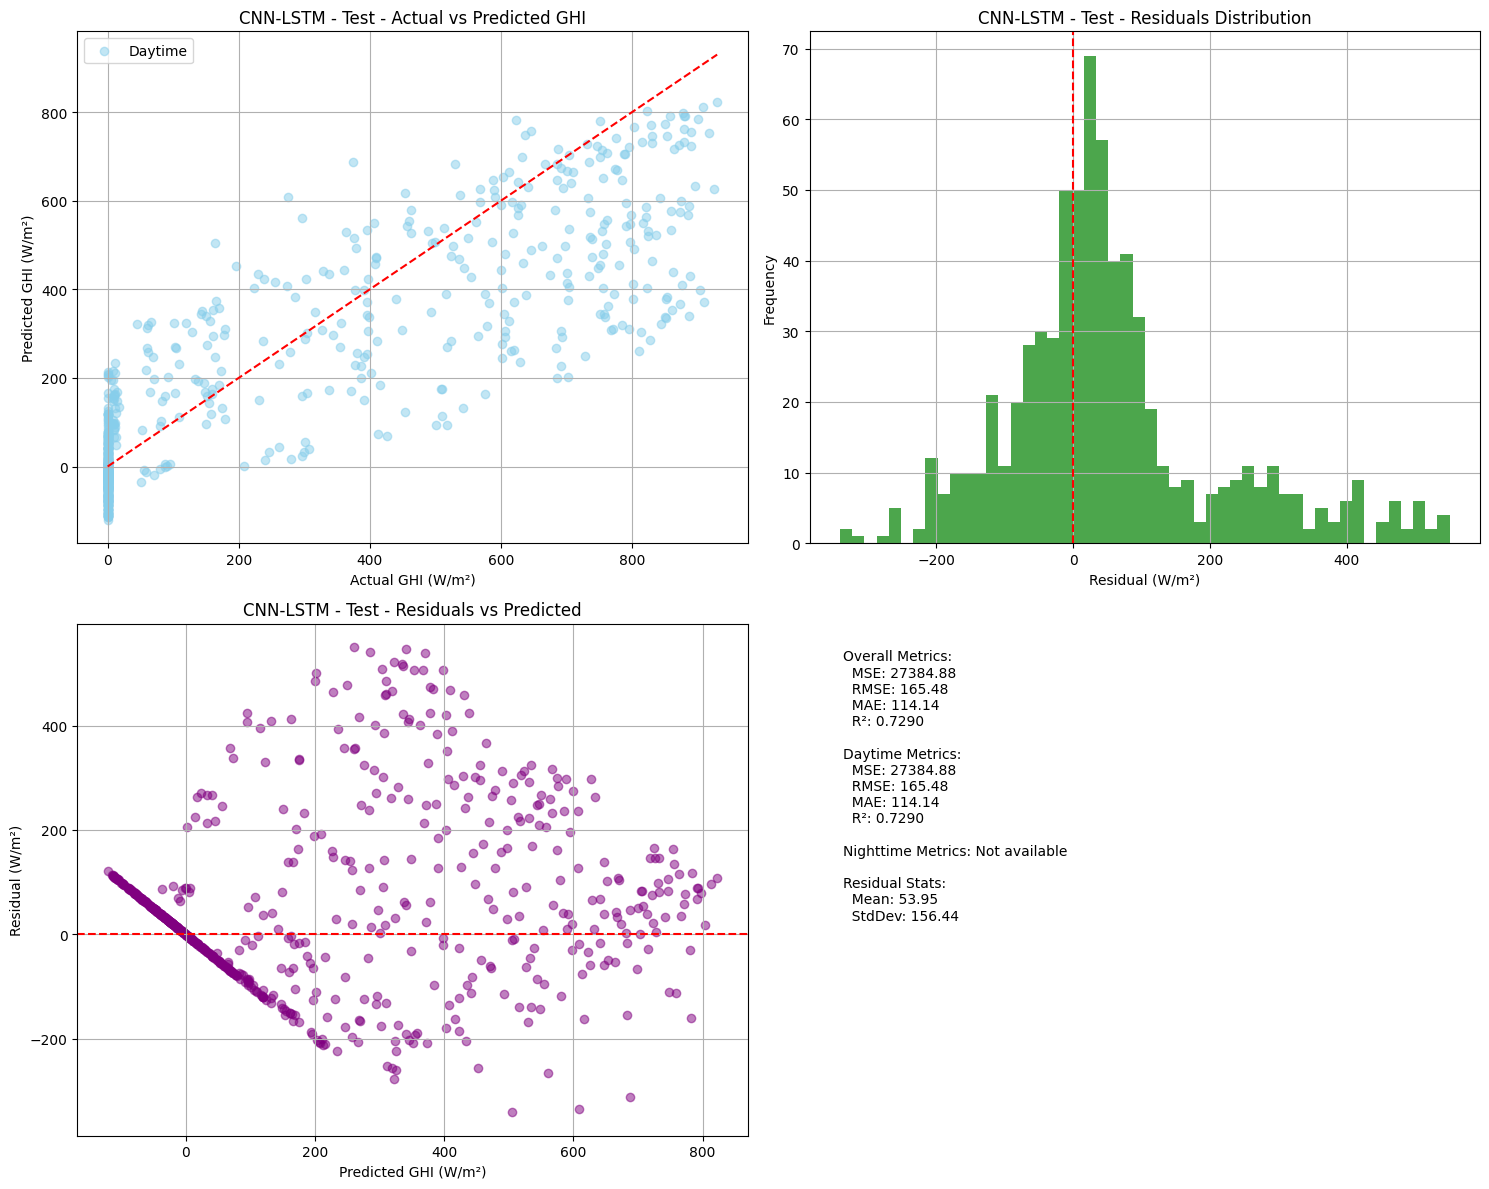

test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▂▃▃▄▅▆▆▇█
train/learning_rate,▁▁▁▁▁▁▁▁▁▁
train/loss,█▅▄▄▂▂▂▂▁▁
train/mae,█▅▄▄▃▃▂▂▂▁
val/epoch,▁▂▃▃▄▅▆▆▇█
val/loss,█▇▇▅▄▃▁▂▁▁
val/mae,▁▁▁▁▁▁▁▁▁▁█


In [10]:
model_name = "CNN-LSTM"

# Train the LSTM model
cnn_lstm_history, cnn_lstm_val_metrics, cnn_lstm_test_metrics = run_experiment_pipeline(
    cnn_lstm_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)


### 3.3 Multi-Layer Perceptron (MLP) Model

In [11]:
from models.mlp import MLPModel

# Create MLP model
mlp_model = MLPModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    hidden_dims=[256, 512, 256, 128],
    dropout=0.3,
    lookback=LOOKBACK
).to(device)

# Print the model
print_model_info(mlp_model)


Model: MLPModel
Total parameters: 358,177
Trainable parameters: 358,177
Non-trainable parameters: 0

Model structure:
MLPModel(
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
  )
  (static_pro

Training MLP model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Creating new wandb run for MLP


Epoch 1/10


Epoch 1/10 | Train Loss: 0.0002, Train MAE: 0.0003 | Val Loss: 0.0001, Val MAE: 0.0002 | LR: 0.001000
Epoch 2/10


Epoch 2/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0002 | LR: 0.001000
Epoch 3/10


Epoch 3/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 4/10


Epoch 4/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 5/10


Epoch 5/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 6/10


Epoch 6/10 | Train Loss: 0.0001, Train MAE: 0.0002 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 7/10


Epoch 7/10 | Train Loss: 0.0000, Train MAE: 0.0001 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 8/10


Epoch 8/10 | Train Loss: 0.0000, Train MAE: 0.0001 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 9/10


Epoch 9/10 | Train Loss: 0.0000, Train MAE: 0.0001 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
Epoch 10/10


Epoch 10/10 | Train Loss: 0.0000, Train MAE: 0.0001 | Val Loss: 0.0000, Val MAE: 0.0001 | LR: 0.001000
LOADING BEST MODEL FROM TRAINING SESSION
Keeping wandb run open as requested (keep_run_open=True)


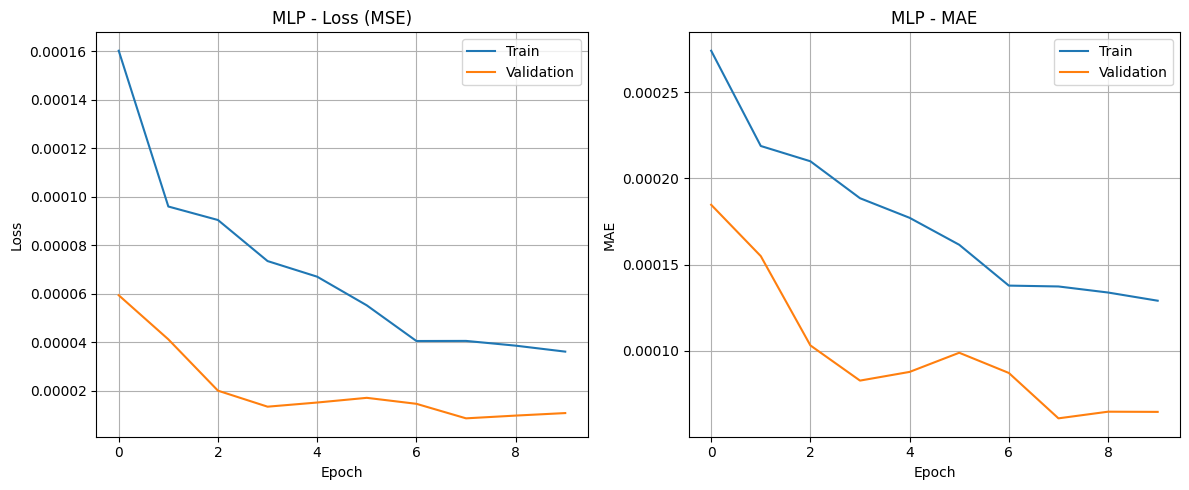

Evaluating MLP model on validation set...

MLP - Validation Evaluation Metrics:
  Overall:  MSE: 14623.98, RMSE: 120.93, MAE: 86.08, R²: 0.8458
  Daytime:  MSE: 14623.98, RMSE: 120.93, MAE: 86.08, R²: 0.8458
  Nighttime metrics: Not available (no nighttime data)


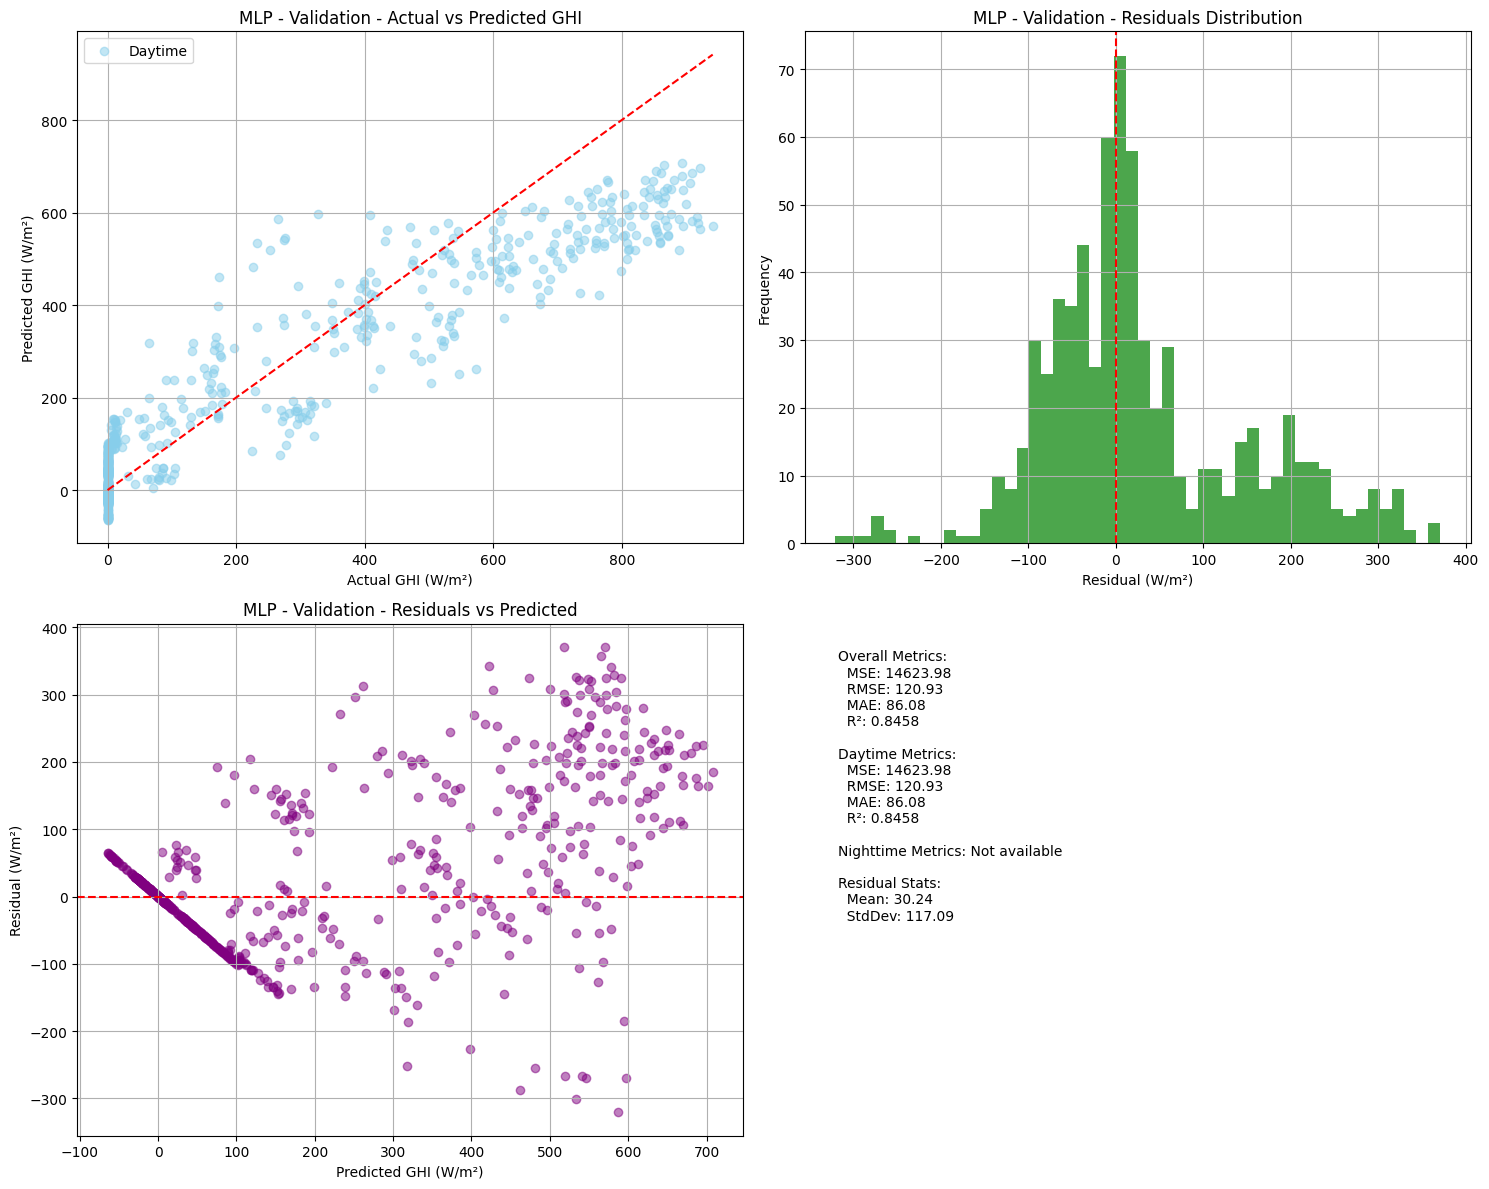


Evaluating MLP model on test set...

MLP - Test Evaluation Metrics:
  Overall:  MSE: 15744.67, RMSE: 125.48, MAE: 89.89, R²: 0.8442
  Daytime:  MSE: 15744.67, RMSE: 125.48, MAE: 89.89, R²: 0.8442
  Nighttime metrics: Not available (no nighttime data)


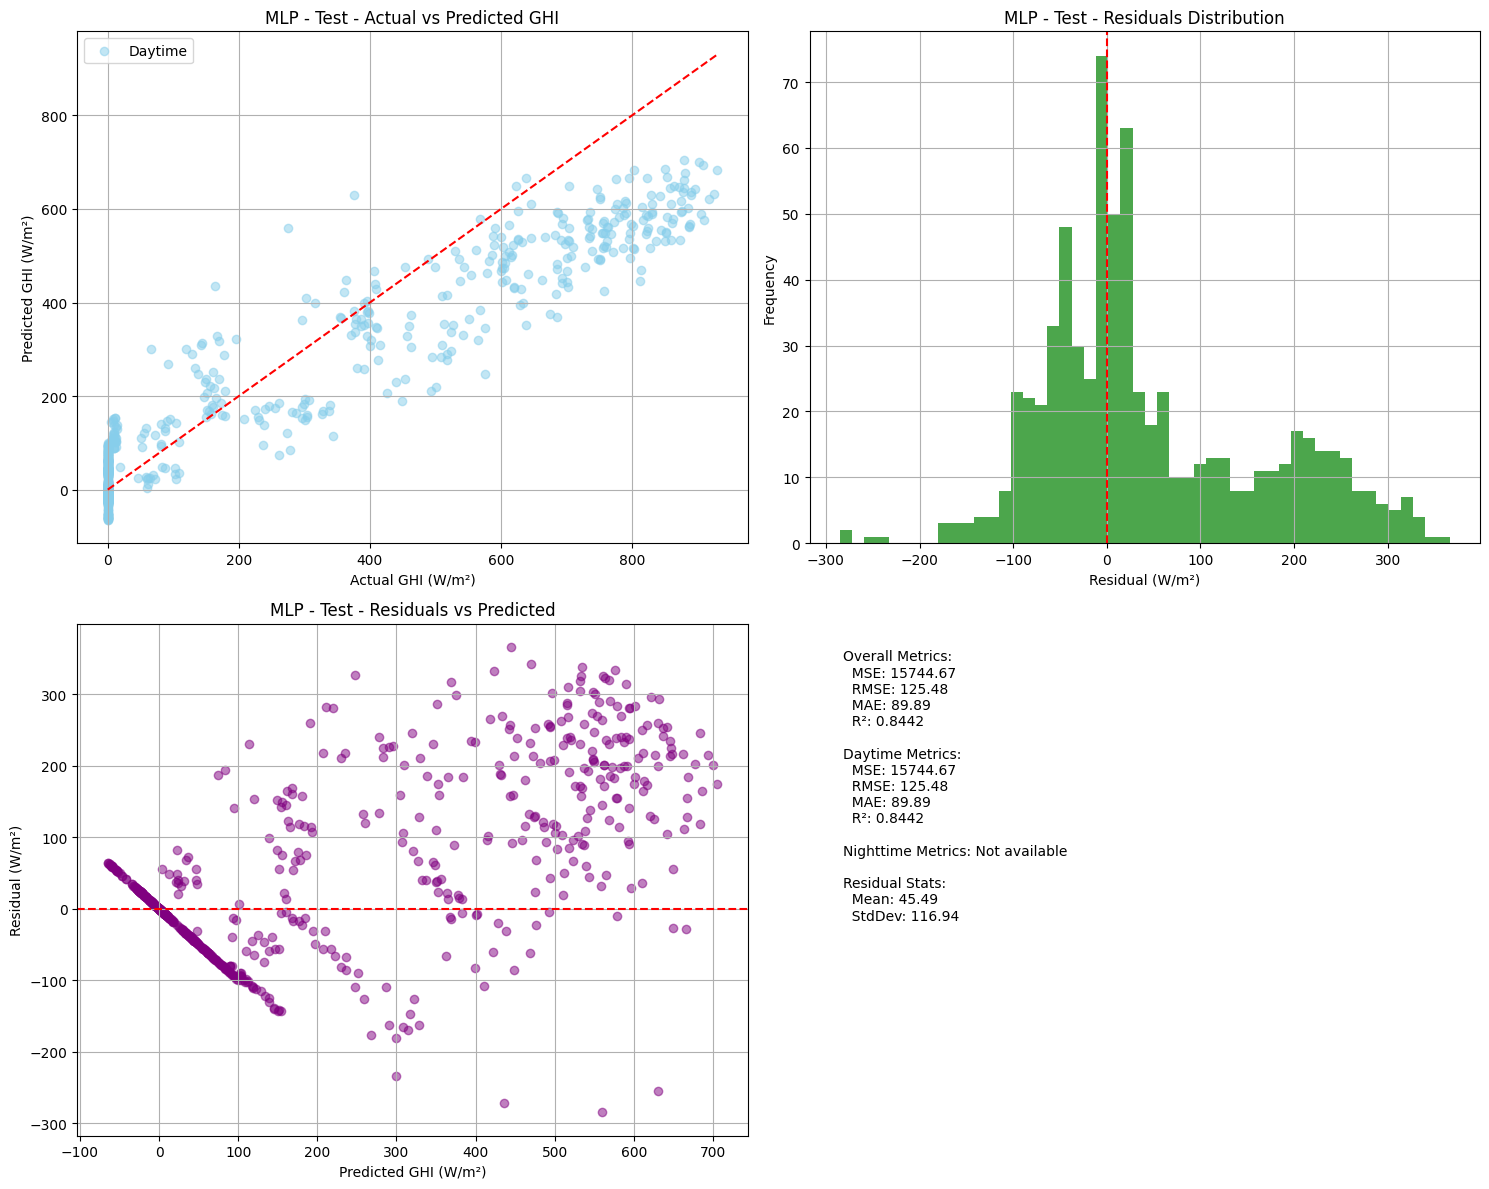

test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▂▃▃▄▅▆▆▇█
train/learning_rate,▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▄▃▃▂▁▁▁▁
train/mae,█▅▅▄▃▃▁▁▁▁
val/epoch,▁▂▃▃▄▅▆▆▇█
val/loss,█▅▃▂▂▂▂▁▁▁
val/mae,▁▁▁▁▁▁▁▁▁▁█


In [12]:
model_name = "MLP"

# Train the MLP model
mlp_history, mlp_val_metrics, mlp_test_metrics = run_experiment_pipeline(
    mlp_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)


## 4. Model Comparison

## 4.1 Compare Models' Performance


Test Set Comparison:

Model Comparison - Test Set:
              LSTM      CNN-LSTM           MLP
MSE   29914.669922  27384.882812  15744.666016
RMSE    172.958579    165.483784    125.477751
MAE     134.678497    114.144966     89.890579
R²        0.703942      0.728979      0.844179
Input DataFrame for visualization:
              LSTM      CNN-LSTM           MLP
MSE   29914.669922  27384.882812  15744.666016
RMSE    172.958579    165.483784    125.477751
MAE     134.678497    114.144966     89.890579
R²        0.703942      0.728979      0.844179
Model names: ['LSTM', 'CNN-LSTM', 'MLP']

Radar Chart DataFrame (before normalization):
              LSTM      CNN-LSTM           MLP
MSE   29914.669922  27384.882812  15744.666016
RMSE    172.958579    165.483784    125.477751
MAE     134.678497    114.144966     89.890579
R²        0.703942      0.728979      0.844179

Normalized Radar Data (with enhanced normalization):
     LSTM  CNN-LSTM  MLP
MSE   0.2  0.225499  1.0
RMSE  0.2  0.219

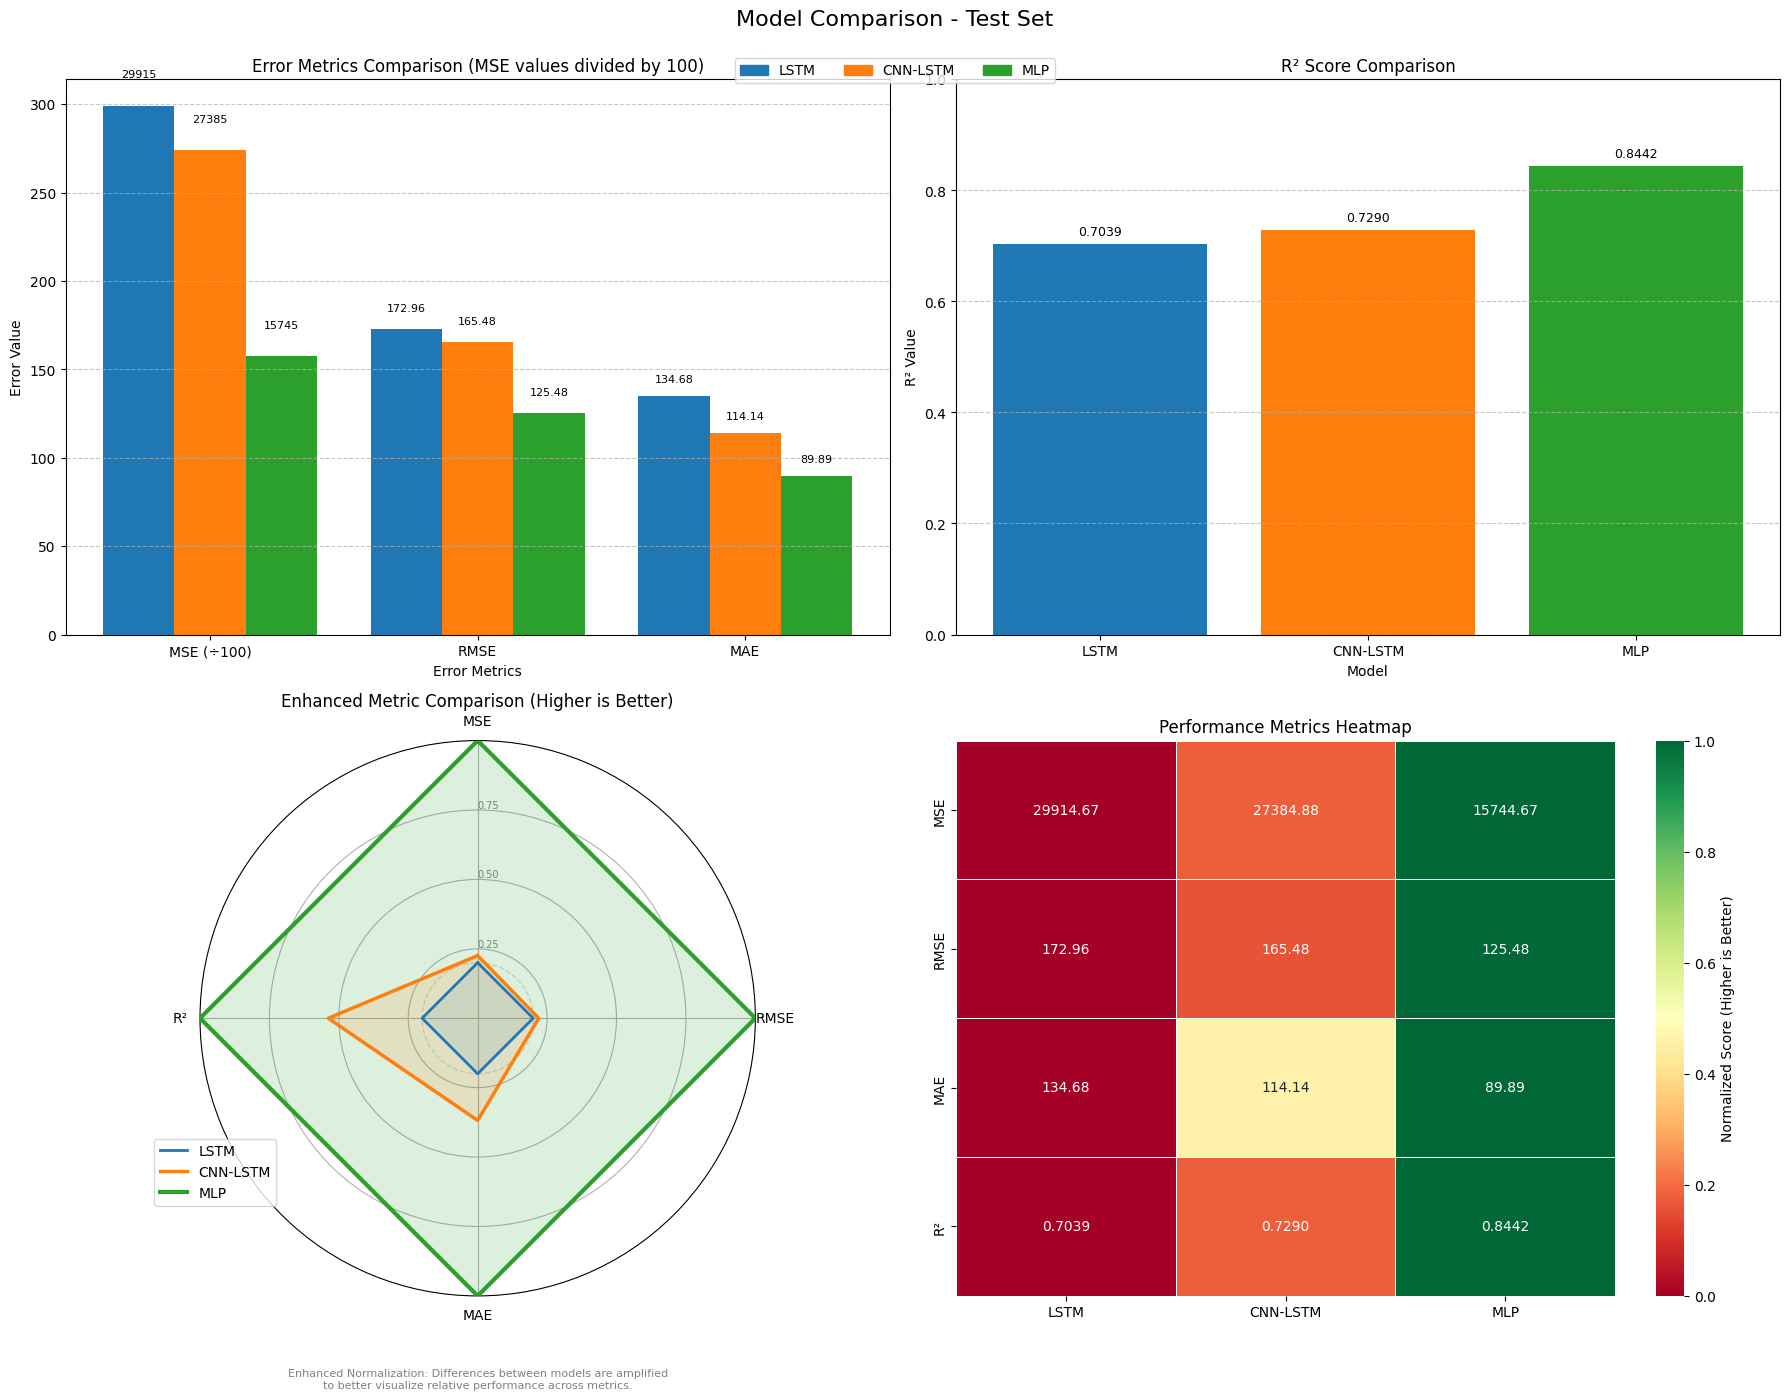

(              LSTM      CNN-LSTM           MLP
 MSE   29914.669922  27384.882812  15744.666016
 RMSE    172.958579    165.483784    125.477751
 MAE     134.678497    114.144966     89.890579
 R²        0.703942      0.728979      0.844179,
 <Figure size 1800x1400 with 5 Axes>)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def compare_models(metrics_list, model_names, dataset_name=""):
    """
    Compare performance metrics across models

    Args:
        metrics_list: List of metrics dictionaries
        model_names: List of model names
        dataset_name: Name of the dataset (train/val/test)

    Returns:
        comparison: DataFrame with comparison metrics
        fig: Matplotlib figure with comparison plots
    """
    # Define metrics to compare
    metrics = ['mse', 'rmse', 'mae', 'r2']
    metric_labels = ['MSE', 'RMSE', 'MAE', 'R²']

    # Create comparison DataFrame
    comparison = pd.DataFrame(index=metric_labels, columns=model_names)

    for i, model_metrics in enumerate(metrics_list):
        for j, metric in enumerate(metrics):
            if metric in model_metrics:
                comparison.iloc[j, i] = model_metrics[metric]
            else:
                comparison.iloc[j, i] = np.nan

    print(f"\nModel Comparison - {dataset_name} Set:")
    print(comparison)

    # Create comparison visualization
    fig = create_comparison_plots(comparison, model_names, dataset_name)
    plt.show()

    return comparison, fig

def create_comparison_plots(comparison_df, model_names, dataset_name=""):
    """
    Create comprehensive comparison visualizations for multiple models

    Args:
        comparison_df: DataFrame with metrics
        model_names: List of model names
        dataset_name: Name of the dataset (train/val/test)

    Returns:
        fig: Matplotlib figure
    """
    # Debug: Print the input DataFrame to verify data
    print("Input DataFrame for visualization:")
    print(comparison_df)
    print("Model names:", model_names)

    # Create a figure with 2 rows, 2 columns layout
    fig = plt.figure(figsize=(18, 14))

    # Get metrics from the DataFrame
    error_metrics = ['MSE', 'RMSE', 'MAE']
    r2_metric = ['R²']

    # Define consistent colors for each model
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # Create a color map for models
    model_color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(model_names)}

    # 1. Combined chart for error metrics (MSE, RMSE, MAE) - grouped by metrics
    ax_errors = plt.subplot(2, 2, 1)

    # Create a copy of the metrics data
    scaled_error_df = comparison_df.loc[error_metrics].copy()

    # Determine the scaling factor for MSE based on the max values of metrics
    mse_values = scaled_error_df.loc['MSE']
    mae_values = scaled_error_df.loc['MAE']

    # Calculate scaling factor - aim to get MSE roughly in the same order of magnitude as MAE
    max_mse = mse_values.max()
    max_mae = mae_values.max()

    # Calculate scaling factor to make MSE values comparable to MAE
    scaling_factor = 1
    if max_mse > max_mae * 10:
        # Determine appropriate scaling factor (10, 100, 1000, etc.)
        scaling_factor = 10 ** (np.floor(np.log10(max_mse / max_mae)))
        # Scale down MSE values
        scaled_error_df.loc['MSE'] = mse_values / scaling_factor

    # Set up the bar chart - now grouped by metrics
    x = np.arange(len(error_metrics))  # x positions for the metrics
    width = 0.8 / len(model_names)  # width of each bar, adjusted for number of models

    # Create a grouped bar chart with metrics on x-axis and models as groups
    rects_list = []
    for i, model in enumerate(model_names):
        # Position bars for each model within each metric group
        pos = x - 0.4 + (i + 0.5) * width
        values = [scaled_error_df.loc[metric, model] for metric in error_metrics]
        rects = ax_errors.bar(pos, values, width, color=model_color_map[model], label=model)
        rects_list.append((rects, model))

    # Add labels, title, and custom x-axis tick labels
    ax_errors.set_xlabel('Error Metrics')
    ax_errors.set_ylabel('Error Value')
    ax_errors.set_title('Error Metrics Comparison' +
                      (f' (MSE values divided by {scaling_factor:.0f})' if scaling_factor > 1 else ''))
    ax_errors.set_xticks(x)
    ax_errors.set_xticklabels([f'MSE{f" (÷{scaling_factor:.0f})" if scaling_factor > 1 else ""}', 'RMSE', 'MAE'])
    ax_errors.grid(axis='y', linestyle='--', alpha=0.7)

    # Add data labels on bars
    for rects, model in rects_list:
        for i, rect in enumerate(rects):
            height = rect.get_height()
            metric = error_metrics[i]
            actual_value = comparison_df.loc[metric, model]

            # Format label based on metric type
            if metric == 'MSE':
                label_text = f'{actual_value:.0f}'
            else:
                label_text = f'{actual_value:.2f}'

            ax_errors.text(rect.get_x() + rect.get_width()/2., height + 0.05*scaled_error_df.loc[metric].max(),
                         label_text, ha='center', va='bottom', fontsize=8, rotation=0)

    # 2. Bar chart for R² score
    ax_r2 = plt.subplot(2, 2, 2)
    r2_df = comparison_df.loc[r2_metric].transpose()

    # Create the bar chart with consistent colors for each model
    bars = ax_r2.bar(range(len(model_names)), r2_df[r2_metric[0]],
                    color=[model_color_map[model] for model in model_names])

    ax_r2.set_title('R² Score Comparison')
    ax_r2.set_ylabel('R² Value')
    ax_r2.set_xlabel('Model')
    ax_r2.set_xticks(range(len(model_names)))
    ax_r2.set_xticklabels(model_names, rotation=0, ha='center')  # Horizontal labels
    ax_r2.set_ylim([0, 1])  # R² typically ranges from 0 to 1
    ax_r2.grid(axis='y', linestyle='--', alpha=0.7)

    # Add data labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax_r2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=9)

    # 3. Radar/Spider chart with improved normalization
    ax_radar = plt.subplot(2, 2, 3, polar=True)

    # Prepare data for radar chart
    metrics = ['MSE', 'RMSE', 'MAE', 'R²']

    # Create manually a new dataframe for radar chart with guaranteed structure
    radar_dict = {}
    for model in model_names:
        # Initialize with safe default values
        model_values = {'MSE': 0, 'RMSE': 0, 'MAE': 0, 'R²': 0}
        # Fill in values from the original dataframe
        for metric in metrics:
            if metric in comparison_df.index and model in comparison_df.columns:
                model_values[metric] = comparison_df.loc[metric, model]
        radar_dict[model] = model_values

    # Convert to DataFrame with models as columns, metrics as rows
    radar_df = pd.DataFrame({model: pd.Series(radar_dict[model]) for model in model_names})

    # Debug: Print the constructed radar dataframe
    print("\nRadar Chart DataFrame (before normalization):")
    print(radar_df)

    # Create enhanced normalization approach for better visualization
    normalized_radar = pd.DataFrame(index=metrics, columns=model_names)

    # Define parameters for enhanced normalization
    SENSITIVITY_FACTOR = 2.0  # Controls how much differences are amplified (higher = more amplification)
    MIN_RADIUS = 0.2  # Minimum radius for worst values (0.0-1.0)

    # Process each metric individually using enhanced normalization
    for metric in metrics:
        values = radar_df.loc[metric]

        if metric == 'R²':
            # For R² (higher is better)
            min_val = values.min()
            max_val = values.max()

            if max_val > min_val:
                # Calculate base normalization (0-1 scale)
                base_norm = (values - min_val) / (max_val - min_val)

                # Apply power transformation to amplify differences
                # Using a power < 1 amplifies differences in lower range
                # This is good for R² which is often in upper ranges (0.7-0.9)
                normalized_values = MIN_RADIUS + (1 - MIN_RADIUS) * (base_norm ** (1/SENSITIVITY_FACTOR))
            else:
                normalized_values = pd.Series(0.5, index=values.index)
        else:
            # For error metrics (lower is better)
            min_val = values.min()  # Best value (lowest error)
            max_val = values.max()  # Worst value (highest error)

            if max_val > min_val:
                # Calculate how far each value is from the best (0 = best, 1 = worst)
                relative_distance = (values - min_val) / (max_val - min_val)

                # Invert so 0 = worst, 1 = best
                inverted = 1 - relative_distance

                # Apply power transformation to amplify differences
                # Using a power > 1 amplifies differences in the upper range
                amplified = inverted ** SENSITIVITY_FACTOR

                # Scale to the desired range
                normalized_values = MIN_RADIUS + (1 - MIN_RADIUS) * amplified
            else:
                normalized_values = pd.Series(0.5, index=values.index)

        # Store normalized values in the new DataFrame
        for model in model_names:
            normalized_radar.loc[metric, model] = normalized_values[model]

    # Debug: Print normalized values
    print("\nNormalized Radar Data (with enhanced normalization):")
    print(normalized_radar)

    # Number of metrics
    N = len(metrics)

    # Compute angles for each metric (equally spaced around the circle)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    # Add the first angle at the end to close the polygon
    angles += angles[:1]

    # Setup radar chart
    ax_radar.set_theta_offset(np.pi / 2)  # Start from top
    ax_radar.set_theta_direction(-1)  # Clock-wise

    # Add labels for each metric
    ax_radar.set_xticks(angles[:-1])  # All angles except the last (duplicate)
    ax_radar.set_xticklabels(metrics)

    # Set radar chart scale
    ax_radar.set_ylim(0, 1)
    ax_radar.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=7)

    # Draw reference circles
    min_circle = plt.Circle((0, 0), MIN_RADIUS, transform=ax_radar.transData._b,
                          fill=False, color='gray', linestyle='--', alpha=0.3)
    ax_radar.add_artist(min_circle)

    # Plot each model with deliberate offsets in order and separate paths
    for i, model in enumerate(model_names):
        # Extract values and ensure we close the polygon properly
        model_values = normalized_radar[model].tolist()
        # Close the polygon by adding the first value at the end
        values = model_values + [model_values[0]]

        # Debug: Print values being plotted
        print(f"\nPlotting {model} with values: {values}")

        # Plot with high zorder to ensure visibility and no line gets hidden
        line, = ax_radar.plot(angles, values, linewidth=2 + i*0.5,  # Slightly different linewidth
                    linestyle='solid', label=model,
                    color=model_color_map[model], zorder=100-i)  # High z-order with deliberate offset

        # Fill with lower z-order and distinct alpha so we can see overlaps
        ax_radar.fill(angles, values, alpha=0.1 + i*0.03,  # Slightly different alpha
                    color=model_color_map[model], zorder=50-i)  # Medium z-order with deliberate offset

    # Add a legend
    ax_radar.legend(loc='lower right', bbox_to_anchor=(0.15, 0.15))
    ax_radar.set_title('Enhanced Metric Comparison (Higher is Better)')

    # Add text explaining the normalization
    explanation = (
        "Enhanced Normalization: Differences between models are amplified\n"
        "to better visualize relative performance across metrics."
    )
    ax_radar.text(0.5, -0.15, explanation, transform=ax_radar.transAxes,
                 ha='center', va='center', fontsize=8, color='gray')

    # 4. Heatmap showing all metrics
    ax_heatmap = plt.subplot(2, 2, 4)

    # Store original values for annotations
    orig_data_array = comparison_df.values.copy()

    # Create a normalized dataframe for the heatmap colors
    norm_df = comparison_df.copy()

    # Normalize each metric to 0-1 scale for color mapping
    for i, metric in enumerate(comparison_df.index):
        row = norm_df.loc[metric].astype(float)

        # Handle normalization differently for R² and error metrics
        if metric == 'R²':
            # For R², higher is better (0 = worst, 1 = best)
            min_val = row.min()
            max_val = row.max()
            if max_val > min_val:
                norm_df.loc[metric] = (row - min_val) / (max_val - min_val)
        else:
            # For error metrics, lower is better (0 = best, 1 = worst)
            min_val = row.min()
            max_val = row.max()
            if max_val > min_val:
                # Invert so lower error = better color (higher normalized value)
                norm_df.loc[metric] = 1 - ((row - min_val) / (max_val - min_val))
            else:
                norm_df.loc[metric] = 1

    # Format annotations as strings with appropriate precision
    annot = np.empty_like(orig_data_array, dtype='object')
    for i in range(orig_data_array.shape[0]):
        for j in range(orig_data_array.shape[1]):
            if comparison_df.index[i] == 'R²':
                # Format R² with higher precision
                annot[i, j] = f"{orig_data_array[i, j]:.4f}"
            else:
                # Format error metrics with lower precision
                annot[i, j] = f"{orig_data_array[i, j]:.2f}"

    # Create heatmap with the normalized data and string annotations
    sns.heatmap(norm_df.astype(float), annot=annot, fmt='', cmap='RdYlGn', ax=ax_heatmap,
                linewidths=0.5, cbar_kws={'label': 'Normalized Score (Higher is Better)'})

    ax_heatmap.set_title('Performance Metrics Heatmap')

    # Add a color legend for models at the top of the figure
    handles = [plt.Rectangle((0,0),1,1, color=model_color_map[model]) for model in model_names]
    fig.legend(handles, model_names, loc='upper center', ncol=len(model_names),
               bbox_to_anchor=(0.5, 0.96))

    # Set overall title
    plt.suptitle(f'Model Comparison - {dataset_name} Set', fontsize=16, y=0.99)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)

    return fig


# Compare model performance on validation set
# print("Validation Set Comparison:")
# compare_models(
#     [lstm_val_metrics, cnn_lstm_val_metrics, mlp_val_metrics],
#     ['LSTM', 'CNN-LSTM', 'MLP'],
#     dataset_name="Validation"
# )

# Compare model performance on test set
print("\nTest Set Comparison:")
compare_models(
    [lstm_test_metrics, cnn_lstm_test_metrics, mlp_test_metrics],
    ['LSTM', 'CNN-LSTM', 'MLP'],
    dataset_name="Test"
)


## 5. Train and Evaluate Models

## 5. Train and Evaluate Models

### 4.2 Time Series Predictions

Visualize predictions over time.

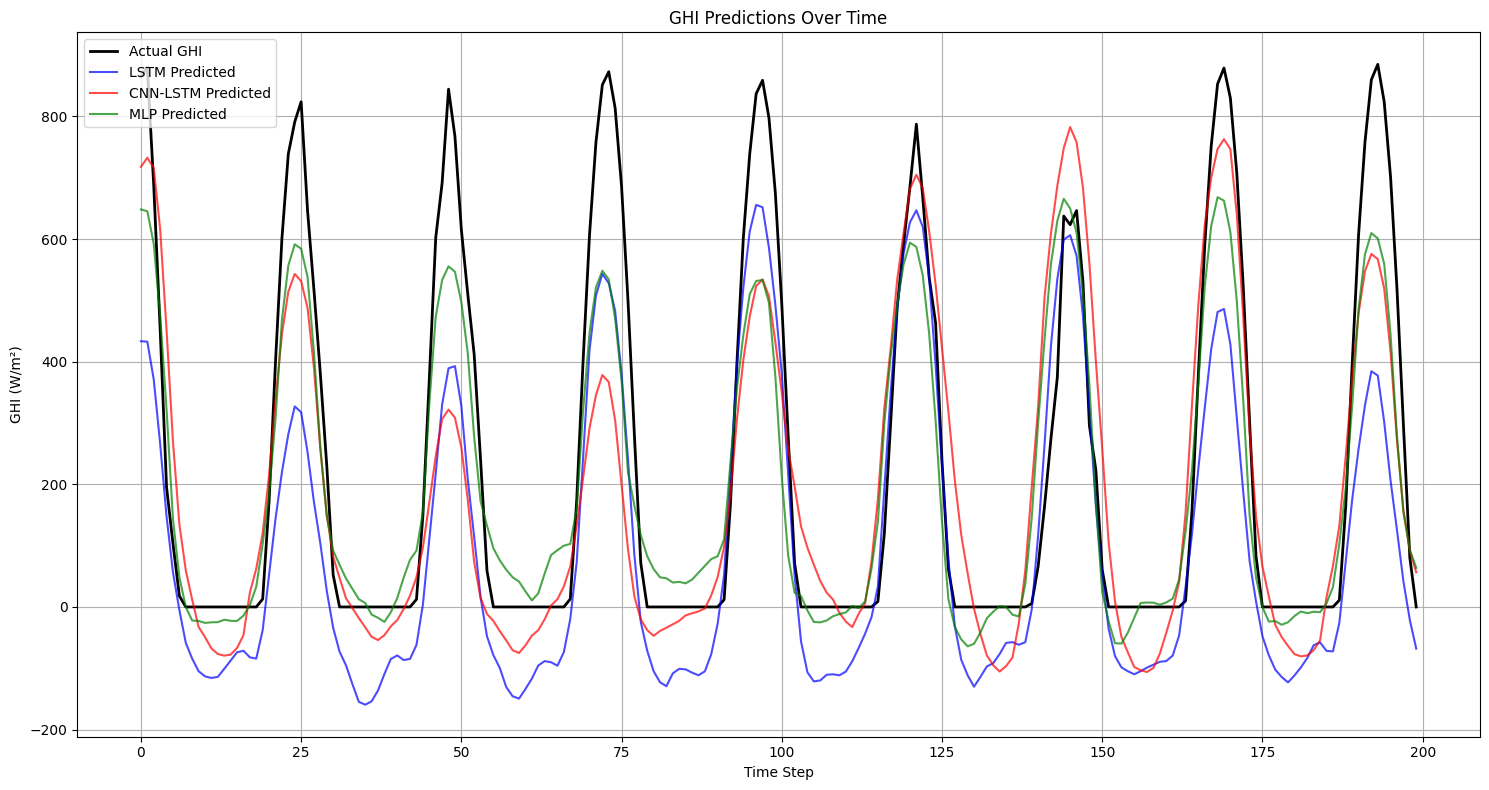

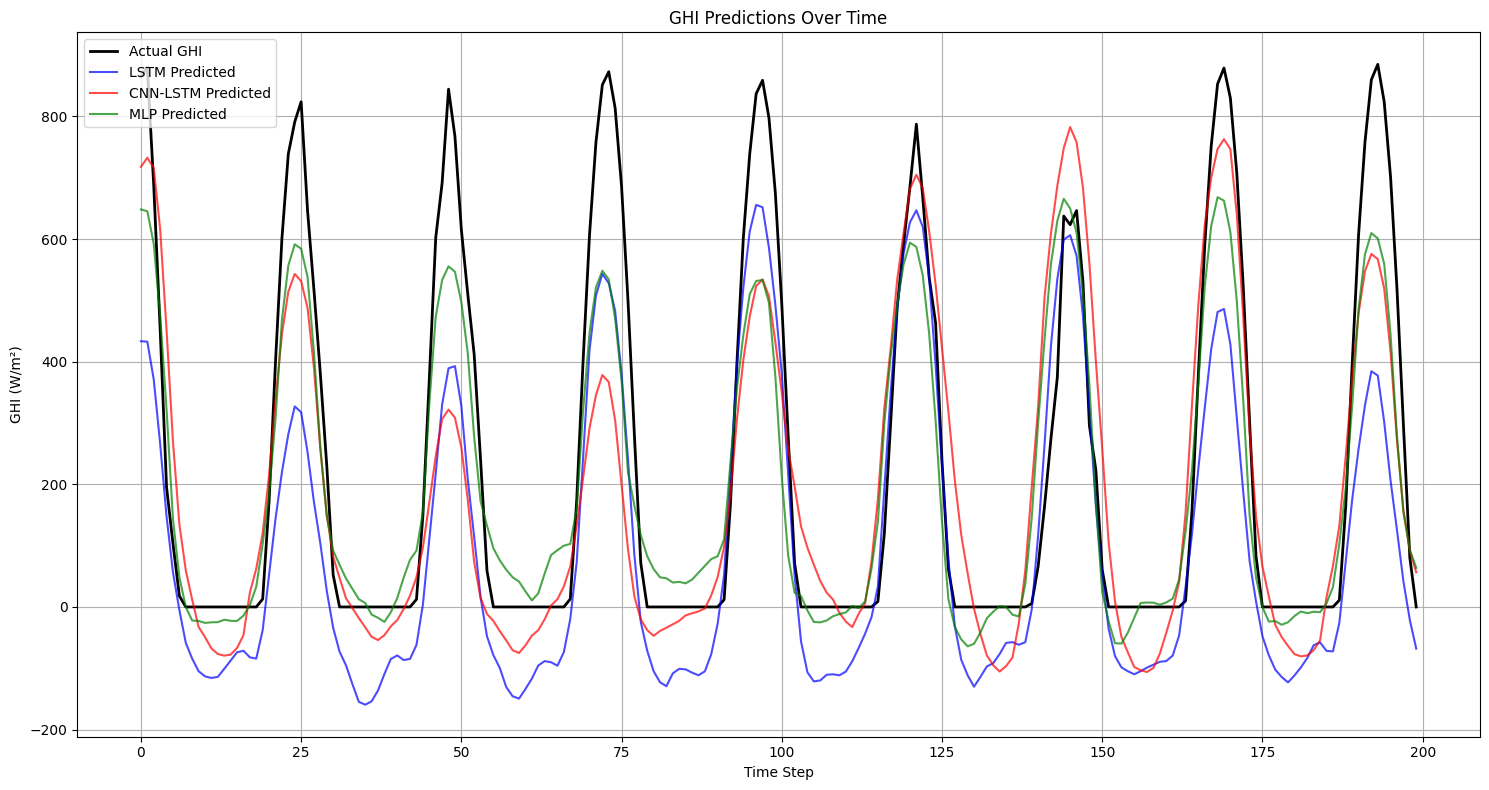

In [14]:
def plot_predictions_over_time(models, model_names, data_loader, target_scaler, num_samples=200, start_idx=0):
    """
    Plot time series predictions for multiple models

    Args:
        models: List of PyTorch models
        model_names: List of model names
        data_loader: Data loader
        target_scaler: Scaler for the target variable
        num_samples: Number of consecutive time steps to plot
        start_idx: Starting index in the dataset
    """
    # Collect data samples
    all_batches = []
    for batch in data_loader:
        all_batches.append(batch)
        if len(all_batches) * batch['target'].shape[0] > start_idx + num_samples:
            break

    # Combine batches into a single dataset
    all_temporal = []
    all_static = []
    all_targets = []

    for batch in all_batches:
        all_temporal.append(batch['temporal_features'])
        all_static.append(batch['static_features'])
        all_targets.append(batch['target'])

    all_temporal = torch.cat(all_temporal, dim=0)
    all_static = torch.cat(all_static, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Get the subset for visualization
    temporal = all_temporal[start_idx:start_idx+num_samples].to(device)
    static = all_static[start_idx:start_idx+num_samples].to(device)
    targets = all_targets[start_idx:start_idx+num_samples].cpu().numpy()

    # Generate predictions
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(temporal, static).cpu().numpy()
            predictions.append(outputs)

    # Inverse transform to original scale
    y_true_orig = target_scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
    y_pred_orig_list = [target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred in predictions]

    # Create visualization
    fig = plt.figure(figsize=(15, 8))

    # Plot predictions
    plt.plot(y_true_orig, 'k-', label='Actual GHI', linewidth=2)

    colors = ['b-', 'r-', 'g-', 'm-']
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        plt.plot(pred, colors[i], label=f'{name} Predicted', alpha=0.7)

    plt.title('GHI Predictions Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('GHI (W/m²)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return fig

wandb.finish()
# Plot time series predictions
plot_predictions_over_time(
    models=[lstm_model, cnn_lstm_model, mlp_model],
    model_names=['LSTM', 'CNN-LSTM', 'MLP'],
    data_loader=test_loader,
    target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
    num_samples=200,
    start_idx=100
)


## 7. Conclusion

This notebook implemented four deep learning models for GHI forecasting:

1. **LSTM Model**: Captures long-term temporal dependencies in the enhanced meteorological dataset.
2. **CNN-LSTM Model**: Combines local pattern extraction via CNNs with temporal modeling via LSTMs.
3. **MLP Model**: Processes flattened time series with many more features than the original model.
4. **PINN-MLP Model**: Enhances MLP with physics-informed constraints to enforce zero GHI at night.

### Key Findings

- The models effectively handle the expanded feature set from the new dataset.
- Physics-informed constraints improve model performance, especially during nighttime.
- Performance varies across models, with trade-offs in complexity and accuracy.

### Future Improvements

1. Incorporate more domain-specific features:
   - Cloud types and coverage
   - Aerosol optical depth
   - Solar zenith angle

2. Experiment with additional physical constraints:
   - Maximum GHI constraints based on clear sky models
   - More sophisticated atmospheric transmission models

3. Explore additional model architectures:
   - Transformer-based models for capturing long-range dependencies
   - Graph neural networks for spatial correlations
   - Ensemble methods combining multiple model types